<a href="https://colab.research.google.com/github/stuser/Python_md/blob/master/object_detection/YOLO_v7/YOLOv7_NIH_CXR_練習題.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NIH CXR – 醫療影像模型訓練(yolo)

資料集說明參考簡報:
https://drive.google.com/file/d/15rKKmlLiPSQ9RQZB1FHmuWqhcTxESfZ2/view?usp=share_link

In [ ]:
import os
import torch

# 設定 CUDA_VISIBLE_DEVICES 只使用第一張 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 設定 GPU 記憶體上限
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(0)
torch.cuda.set_per_process_memory_fraction(0.5) #每個process最多佔用GPU_50%的記憶體

# 下載所需檔案 (YOLOv7, Dataset)

In [ ]:
#!wget https://github.com/TA-aiacademy/course_3.0/releases/download/CVCNN_Data/yolov7.zip
#!unzip yolov7.zip

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1157 (delta 10), reused 15 (delta 8), pack-reused 1139
Receiving objects: 100% (1157/1157), 70.42 MiB | 30.30 MiB/s, done.
Resolving deltas: 100% (498/498), done.


In [ ]:
%pip install -qr /content/yolov7/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import random
import PIL
import sys
from IPython.display import Image

sys.path.insert(0,'./yolov7')

NIH資料集(357mb)連結: https://drive.google.com/file/d/1yx4ko476lphagUKjMEJGtYLWgIiLDngo/view?usp=share_link

In [ ]:
!pip install -q gdown

!gdown --id 1yx4ko476lphagUKjMEJGtYLWgIiLDngo

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yx4ko476lphagUKjMEJGtYLWgIiLDngo
To: /content/NIH.zip
100% 357M/357M [00:02<00:00, 166MB/s]


In [ ]:
!unzip NIH.zip > logs

In [ ]:
#本次物件偵測任務,只偵測8種病徵
pathology_list = ['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

# EDA - NIH CXR

原始NIH-CXR資料集,共有14類病徵:
- Atelectasis , 肺不張
- Cardiomegaly , 心臟擴大
- Effusion , 積液/積水
- Infiltration , 浸潤
- Mass , 塊/腫瘤
- Nodule , 結核
- Pneumonia , 肺炎
- Pneumothorax , 氣胸
- Consolidation , 肺部實質病變
- Edema , 浮腫
- Emphysema , 氣腫
- Fibrosis , 纖維化
- Pleural_Thickening , 胸膜增厚
- Hernia , 疝氣

其餘:
Nothing , 60412張 not found

In [ ]:
df_data = pd.read_csv("https://raw.githubusercontent.com/ingus-t/SPAI/master/resources/Data_Entry_2017.csv")

In [ ]:
df_data.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
# 指定要比對的資料夾路徑
train_folder_path = 'NIH/train/images'
test_folder_path = 'NIH/valid/images'

# 讀取指定資料夾中的檔案名稱
train_file_names = os.listdir(train_folder_path)
test_file_names = os.listdir(test_folder_path)

# 找出指定資料夾中的檔案在DataFrame中的索引
train_matching_indexes = df_data[df_data['Image Index'].isin(train_file_names)].index
test_matching_indexes = df_data[df_data['Image Index'].isin(test_file_names)].index

# 輸出結果
print("train set檔案總數:",len(train_file_names),"核對筆數:",len(train_matching_indexes))
print("test set檔案總數:",len(test_file_names),"核對筆數:",len(test_matching_indexes))

train set檔案總數: 792 核對筆數: 792
test set檔案總數: 88 核對筆數: 88


我們針對train set的檔案進行分析

In [ ]:
df_NIH = df_data[df_data['Image Index'].isin(train_file_names)]

In [ ]:
df_NIH

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
151,00000032_037.png,Cardiomegaly|Edema|Infiltration,37,32,55,F,AP,2500,2048,0.168000,0.168000,NaN
310,00000072_000.png,Atelectasis,0,72,67,F,PA,2450,2839,0.143000,0.143000,NaN
596,00000147_001.png,Atelectasis,1,147,66,F,PA,2742,2948,0.143000,0.143000,NaN
608,00000149_006.png,Atelectasis,6,149,71,M,AP,2500,2048,0.168000,0.168000,NaN
614,00000150_002.png,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,3056,2544,0.139000,0.139000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
111704,00030606_006.png,Emphysema|Pneumothorax,6,30606,59,M,PA,2021,2021,0.194311,0.194311,NaN
111791,00030634_000.png,Effusion,0,30634,60,F,PA,2544,3056,0.139000,0.139000,NaN
111793,00030635_001.png,Atelectasis|Effusion,1,30635,51,F,PA,1798,1815,0.194314,0.194314,NaN
111807,00030636_004.png,Atelectasis|Infiltration,4,30636,45,M,AP,3056,2544,0.139000,0.139000,NaN


In [ ]:
# Find class distribution for all 15 classes:
df_NIH.loc[:, 'Finding Labels'] = df_NIH['Finding Labels'].str.replace('|',' ')
df_labels_cnt = df_NIH['Finding Labels'].str.split(expand=True).stack().value_counts()

<ipython-input-13-50ccedc4c66a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_NIH.loc[:, 'Finding Labels'] = df_NIH['Finding Labels'].str.replace('|',' ')
<ipython-input-13-50ccedc4c66a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NIH.loc[:, 'Finding Labels'] = df_NIH['Finding Labels'].str.replace('|',' ')


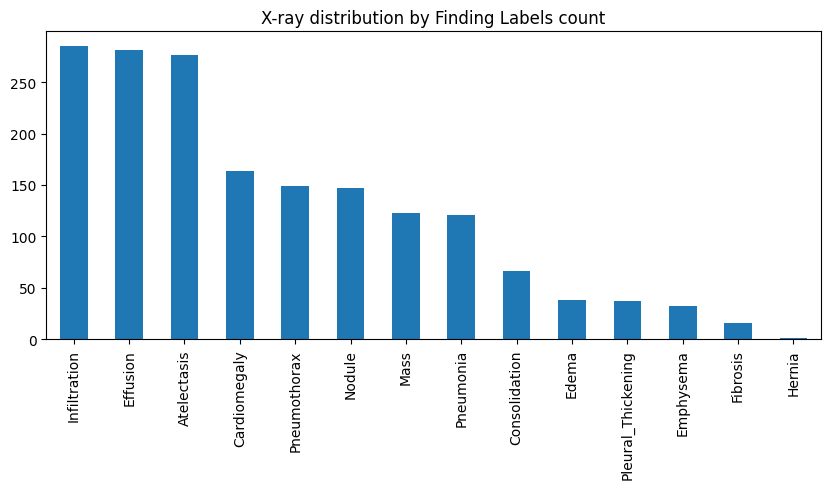

In [ ]:
ax = df_labels_cnt.plot.bar(x='Finding Labels', y='Count', figsize=(10,4),title='X-ray distribution by Finding Labels count')

### X-ray view position

In [ ]:
from collections import Counter
import collections

count = Counter(df_NIH['View Position'])
count

Counter({'AP': 360, 'PA': 432})

<Axes: ylabel='count'>

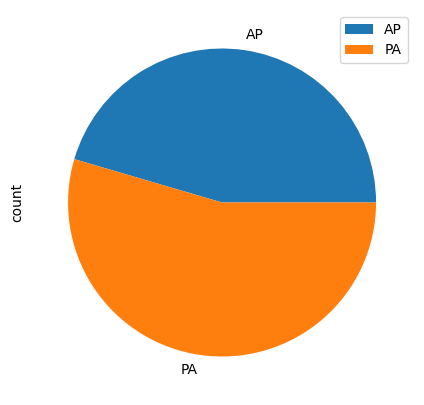

In [ ]:
pie = pd.DataFrame({'count': [count['AP'], count['PA']]}, index=['AP', 'PA'])
pie.plot.pie(y='count', figsize=(5, 5))

### Gender

In [ ]:
a = dict(Counter(df_NIH['Patient Gender']))
a

{'F': 339, 'M': 453}

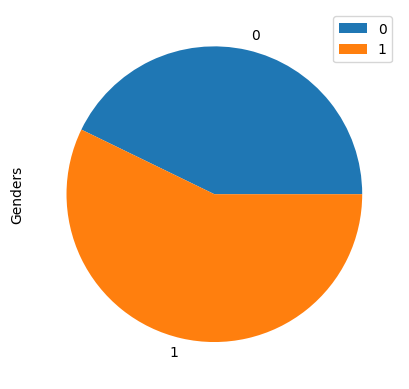

In [ ]:
#draw the graph
temp_df = pd.DataFrame({'gender': list(a.keys()), 'Genders': list(a.values())})
ax = temp_df.plot.pie(x='gender', y='Genders', rot=0)

### Age distribution

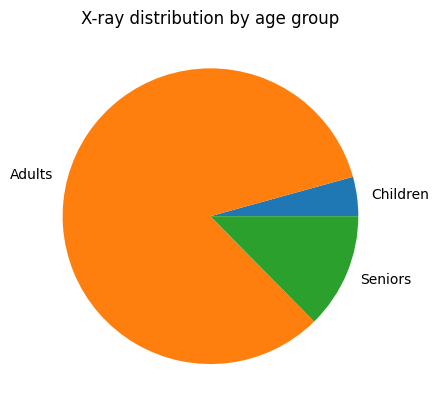

Children: 34, 4.29%
Adults: 658, 83.08%
Seniors: 100, 12.63%


In [ ]:
# age groups: 0 - 18, 18 - 65, 65+
age_classes = ['Children','Adults','Seniors']

# Age group distribution
df_test = df_NIH
children = len(df_test[df_test['Patient Age'] < 18])
adults = len(df_test[(df_test['Patient Age'] >= 18) & (df_test['Patient Age'] <= 65)])
seniors = len(df_test[df_test['Patient Age'] > 65])
count_all = len(df_NIH)

y_axis = [children,adults,seniors]
plt.pie(y_axis, labels = age_classes)
title = "X-ray distribution by age group"
plt.title(title)
plt.show()

children_pct = str(round(children/count_all*100,2))
adults_pct   = str(round(adults  /count_all*100,2))
seniors_pct  = str(round(seniors /count_all*100,2))

print("Children: " + str(children) + ', ' + children_pct + '%')
print("Adults: "   + str(adults)   + ', ' + adults_pct   + '%')
print("Seniors: "  + str(seniors)  + ', ' + seniors_pct  + '%')

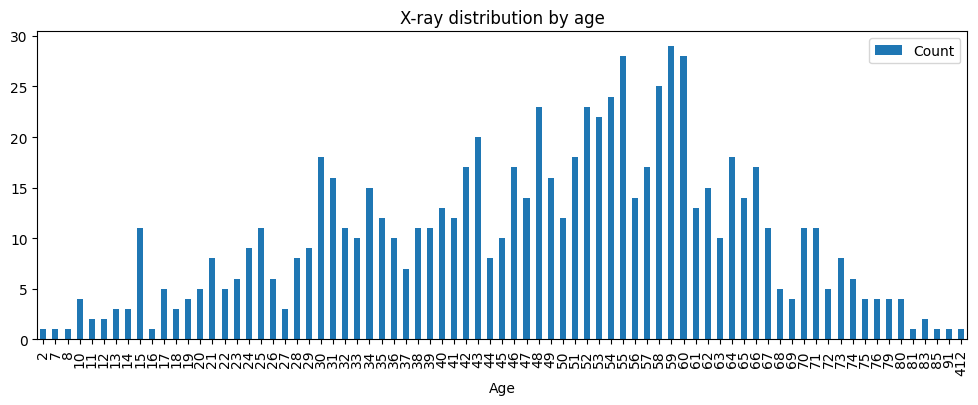

In [ ]:
# TODO - many patients have more than 1  x-rays taken, so this distribution is not entirely accurate

unordered_dict = dict(Counter(df_NIH['Patient Age']))
# make an ordered list, so the graph makes more sense
ordered_list = collections.OrderedDict(sorted(unordered_dict.items()))

#draw the graph
temp_df = pd.DataFrame({'Age': list(ordered_list.keys()), 'Count': list(ordered_list.values())})
ax = temp_df.plot.bar(x='Age', y='Count', figsize=(12,4),title='X-ray distribution by age')

In [ ]:
df_NIH['Patient Age'].sort_values(ascending=False).head(20)

20852     412
108421     91
2761       85
27010      83
48063      83
93364      81
111926     80
67725      80
86623      80
2778       80
67738      79
92882      79
14914      79
92889      79
68252      76
107339     76
61060      76
81414      76
77293      75
26026      75
Name: Patient Age, dtype: int64

# YOLOv7 實作

**實作前請確認各資料匣放置路徑**
- NIH資料匣需放到yolov7專案資料匣內


In [ ]:
name = 'NIH'  # 資料集名稱
classes = pathology_list  # 修改自己的類別

train_image_path = f'{name}/train/images/'
train_label_path = f'{name}/train/labels/'
valid_image_path = f'{name}/valid/images/'
valid_label_path = f'{name}/valid/labels/'

if not os.path.exists(train_image_path):
    os.makedirs(train_image_path)
if not os.path.exists(train_label_path):
    os.makedirs(train_label_path)
if not os.path.exists(valid_image_path):
    os.makedirs(valid_image_path)
if not os.path.exists(valid_label_path):
    os.makedirs(valid_label_path)

## 2. 更改設定檔案
- 修改 cfg/training/yolov7.yaml
- 修改 data/coco.yaml 製作一個自己資料集的 yaml

## 模型訓練參數
執行訓練，訓練參數介紹：
- --weights : 預先訓練的權重路徑(weights/yolov7_training.pt)
- --cfg：模型設定檔案路徑(cfg/training/yolov7-NIH.yaml)
- --data：資料集設定檔案路徑(data/NIH.yaml)
- --device：GPU設定
- --batch-size：一次訓練照片張數
- --epoch： 訓練圈數

其他可調控參數可置train.py中察看

### Single GPU finetuning for custom dataset

```
# finetune p5 models
python train.py --workers 8 --device 0 --batch-size 32 --data data/custom.yaml --img 640 640 --cfg cfg/training/yolov7-custom.yaml --weights 'yolov7_training.pt' --name yolov7-custom --hyp data/hyp.scratch.custom.yaml

# finetune p6 models
python train_aux.py --workers 8 --device 0 --batch-size 16 --data data/custom.yaml --img 1280 1280 --cfg cfg/training/yolov7-w6-custom.yaml --weights 'yolov7-w6_training.pt' --name yolov7-w6-custom --hyp data/hyp.scratch.custom.yaml
```



## 結果呈現

In [ ]:
IMG_FILE = 'NIH/valid/images/00000211_016.png'

#IMG_FILE = 'NIH/train/images/00004342_002.png'

In [ ]:
import PIL
import sys
import numpy as np
from IPython.display import Image


#讀入照片，轉為numpy array格式。
image = PIL.Image.open(IMG_FILE)
image = np.asarray(image)
image.shape

(1024, 1024)